In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
from numba import njit

## step1 数据加载

In [2]:
"""
Santa的接待安排
圣诞节前100天，Santa开放了workshop，欢迎以家庭单位的参观，如何更合理的安排这些家庭参观？
每个家庭有10个选择choice0-9，数字代表了距离圣诞节的天数，比如 1代表12月24日，
每个家庭必须并且只安排一次参观
家庭数量 5000，即family_id 为[0, 4999]，每天访问的人数需要在125-300人
为了更合理的计算Santa的安排能力，我们使用preference cost和accounting penalty两个指标
1）preference cost，代表Santa的个性化安排能力
2）accounting penalty，代表Santa安排的财务成本
每天接待的人员数N(d)如果大于125，就会拥挤，产生过多的清洁成本
最终的 Score = preference cost + accounting penalty
最终提交每个家庭的安排 submission.csv
"""
#数据加载
data = pd.read_csv("family_data.csv")
data.head()

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4


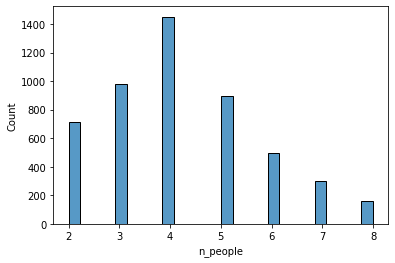

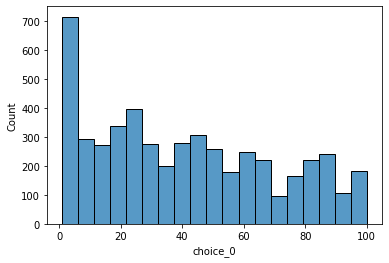

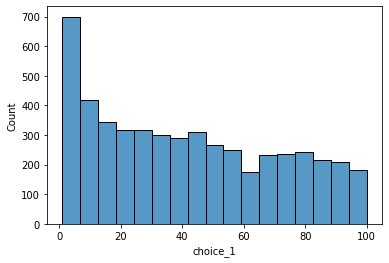

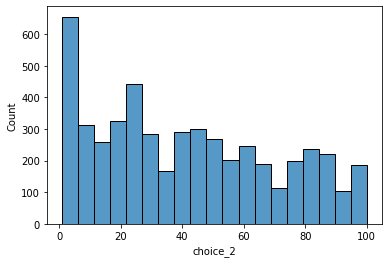

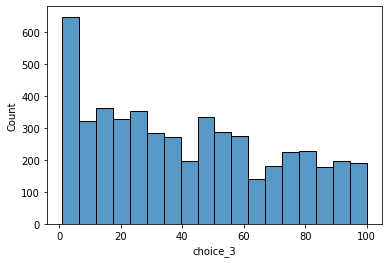

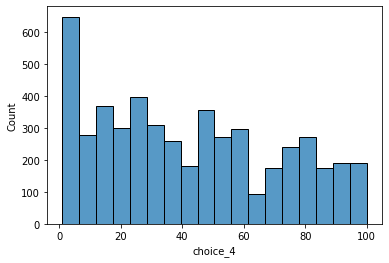

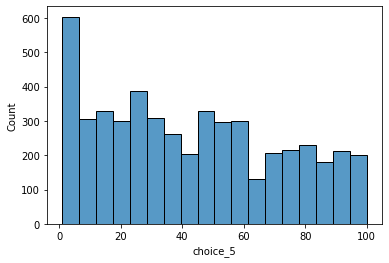

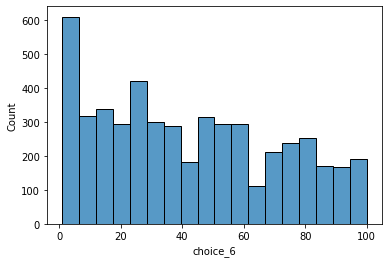

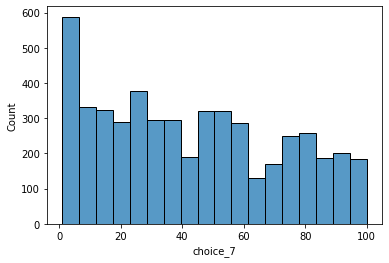

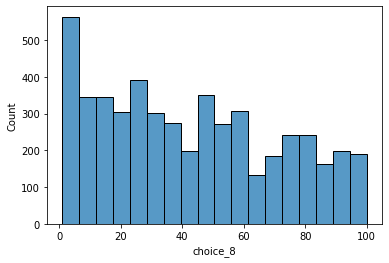

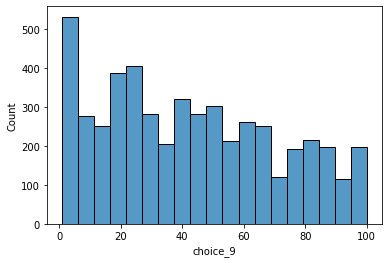

In [3]:
#EDA
#家庭人数分布
sns.histplot(data["n_people"])
plt.show()
#拜访天数分布情况
for i in range(10):
    sns.histplot(data["choice_"+"{}".format(i)])
    plt.show()

## step2 数据预处理
+ 1)计算Perference Cost矩阵 pcost_mat
+ 2)计算Accounting Cost矩阵 acost_mat
+ 3)计算每个家庭人数family_size
+ 4)计算每个家庭的倾向选择(choice)desired

In [4]:
#条件常量
NFAMILY = 5000
NDAY = 100
#NCHOICE = 10
MAXPEOPLE = 300
MINPEOPLE =125

In [5]:
def get_family_cost(choice,n):
    """
    计算给定家庭在不同选择下的花费
    """
    if choice == 0:
        cost = 0
    elif choice == 1:
        cost = 50
    elif choice == 2:
        cost = 50 + n*9
    elif choice == 3:
        cost = 100 + n*9
    elif choice == 4:
        cost = 200 + n * 9
    elif choice == 5:
        cost = 200 + n * 18
    elif choice == 6:
        cost = 300 + n * 18
    elif choice == 7:
        cost = 300 + n * 36
    elif choice == 8:
        cost = 400 + n * 36
    elif choice == 9:
        cost = 500 + n * (36 + 199)
    else:
        cost = 500 + n * (36 + 398)
    return cost

In [6]:
def get_pcost_matrix():
    """
    计算每个家庭在活动期内的preference cost    
    """
    #初始化preference cost matrix
    pcost_matrix = np.full(shape = (NFAMILY,NDAY),fill_value = 999999)
    #print(pcost_matrix)
    #计算pcost  
    for f in data["family_id"]:
        #按最大值填充矩阵
        n_people = data.iloc[f]["n_people"]    
        pcost_matrix[f,:] = get_family_cost(10,n_people)        
        #按家庭choice更新pcost
        for i in range(10):
            days = data.iloc[f]["choice_" +str(i)]
            cost = get_family_cost(i,n_people)            
            pcost_matrix[f,days-1] = cost       
    return pcost_matrix          

In [7]:
def get_acost_matrix():
    """
    计算活动期间由于人数过多产生的财务费用accounting penalty
    """
    #按当天和前一天所有的人数组合300*300，另外考虑0人的情况
    acost_matrix = np.zeros(shape =(MAXPEOPLE+1,MAXPEOPLE+1),dtype = np.float64)
    #计算acost
    for i in range(acost_matrix.shape[0]): #当天安排的人数i+1
        for j in range(acost_matrix.shape[1]): #前一天安排的人数 j +1
            diff = abs(i  - j)
            acost_matrix[i, j] = max(0,(i - 125) / 400 * i ** (1/2 + diff/50))
    return acost_matrix   

In [8]:
#数据预处理
pcost_mat = get_pcost_matrix()
acost_mat = get_acost_matrix()
print(acost_mat)
family_size = data["n_people"].values
# print(family_size)
#每个家庭的选择
desired = data.values[:,1:-1] -1 #-1是为了和pcost,acost矩阵匹配
# print(desired)
#总参与人数
total_people = data["n_people"].values.sum()
# print(total_people)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [4.16316072e+15 3.71482922e+15 3.31477861e+15 ... 7.46610759e+00
  8.36716954e+00 9.37697794e+00]
 [4.79555148e+15 4.27883100e+15 3.81778713e+15 ... 8.43020770e+00
  7.52185316e+00 8.43020770e+00]
 [5.52415954e+15 4.92860244e+15 4.39725208e+15 ... 9.51970597e+00
  8.49339085e+00 7.57772228e+00]]


## 使用LP和MLP求解规划方案
+ 1)先用LP对绝大部分家庭进行规划
+ 2)再使用MLP对剩余家庭进行规划
+ 3)汇总两边的结果 => 最终规划方案

In [9]:
def solveLP():
    """
    线性规划求解
    """   
    solver = pywraplp.Solver("santa",pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    #参观期间每天都有哪些家庭准备选择
    #family i 在choice为第j天
    candidates = dict()
    #定义变量
    x = {}
    for i in range(NFAMILY):
        for j in desired[i,:]:
            candidates.setdefault(j,[])
            candidates[j].append(i) 
            #定义变量x[i,j],i代表family_id,j代表 第j天参观
            x[i,j] = solver.BoolVar("x[%i,%i]"%(i,j))
    #统计每天来的人数
    daily_people = [solver.Sum([family_size[i] *x[i,j] for i in candidates[j]]) for j in range(NDAY)]
    #print(daily_people[0])
    #每个家庭在10个choice出现的情况
    family_presence = [solver.Sum(x[i,j] for j in desired[i,:]) for i in range(NFAMILY)]   
    #print(family_presence[1221])
    #定义目标函数
    #pcost
    preference_cost = solver.Sum([pcost_mat[i,j] * x[i,j] for i in range(NFAMILY) for j in desired[i,:]])     
    
    #最小化preference_cost                                  
    solver.Minimize(preference_cost)
    #设置约束条件
    #前后两天人数差不能超过25人
    for i in range(NDAY-1):
        solver.Add(daily_people[i +1] - daily_people[i] <= 25)
        solver.Add(daily_people[i] -daily_people[i+1] <=25)        
    #每个家庭仅能出现一个choice
    for i in range(NFAMILY):
        solver.Add(family_presence[i] == 1)
    #每天的承载不小于MINPEOPLE
    for j in range(NDAY):
        solver.Add(daily_people[j] >= MINPEOPLE)
        #每天的承载不大于MAXPEOPLE
        solver.Add(daily_people[j] <= MAXPEOPLE)
    #求解
    answer = solver.Solve()
    print("是否有解：",answer == solver.OPTIMAL)
    #查看求解结果
    temp = [(i,j,x[i,j].solution_value()) for i in range(NFAMILY) for j in desired[i,:] if x[i,j].solution_value() >0]
    result = pd.DataFrame(temp,columns=["family_id","days",'result'])       
    return result

In [10]:
%%time
result = solveLP()
result

是否有解： True
Wall time: 29.2 s


,family_id,days,result
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5074,4995,15,1.0
5075,4996,87,1.0
5076,4997,31,1.0
5077,4998,91,1.0


In [11]:
# print(result["family_id"].value_counts())

In [12]:
#设置阈值，找到已安排的家庭
threshold = 0.99
assigned_df = result[result.result > 0.99].copy()
assigned_df

,family_id,days,result
0,0,51,1.0
1,1,25,1.0
2,2,99,1.0
3,3,1,1.0
4,4,52,1.0
...,...,...,...
5074,4995,15,1.0
5075,4996,87,1.0
5076,4997,31,1.0
5077,4998,91,1.0


In [13]:
#没有安排的家庭
unassigned_df = result[(result.result <= threshold) & (result.result >= 1- threshold)]
unassigned_df = unassigned_df["family_id"].unique()
print("没有安排的家庭数：",len(unassigned_df))
unassigned_df

没有安排的家庭数： 68


array([  59,  240,  357,  476,  488,  500,  610,  724,  805,  926,  941,
        961,  965, 1012, 1106, 1176, 1218, 1235, 1387, 1444, 1484, 1536,
       1610, 1611, 1653, 1720, 1905, 1977, 2004, 2101, 2135, 2229, 2318,
       2344, 2353, 2395, 2641, 2778, 2862, 2874, 3033, 3104, 3118, 3228,
       3278, 3280, 3348, 3470, 3504, 3642, 3649, 3786, 4045, 4077, 4084,
       4404, 4421, 4431, 4471, 4518, 4628, 4820, 4850, 4869, 4886, 4912,
       4914, 4961], dtype=int64)

## 对剩余未安排的家庭进行安排

In [14]:
#计算每天已安排的人数
assigned_df["family_size"] = family_size[assigned_df["family_id"]]
assigned_df

,family_id,days,result,family_size
0,0,51,1.0,4
1,1,25,1.0,4
2,2,99,1.0,3
3,3,1,1.0,2
4,4,52,1.0,4
...,...,...,...,...
5074,4995,15,1.0,4
5075,4996,87,1.0,2
5076,4997,31,1.0,6
5077,4998,91,1.0,5


In [15]:
#按照天进行聚合
occupancy = assigned_df.groupby("days").family_size.sum().values
occupancy

array([290, 271, 294, 299, 263, 242, 223, 247, 273, 297, 288, 292, 275,
       250, 245, 272, 292, 292, 271, 248, 223, 244, 264, 291, 292, 296,
       273, 249, 234, 251, 278, 283, 252, 235, 205, 184, 202, 233, 253,
       226, 210, 183, 204, 229, 247, 281, 256, 223, 204, 198, 222, 248,
       256, 220, 208, 185, 173, 196, 219, 198, 174, 141, 124, 121, 149,
       170, 178, 158, 136, 123, 125, 135, 158, 185, 158, 135, 121, 125,
       142, 167, 186, 167, 138, 120, 128, 155, 174, 203, 177, 152, 130,
       122, 130, 158, 183, 158, 128, 125, 122, 124], dtype=int64)

In [16]:
#更新可安排容量的限值
min_occupancy = np.array([max(0,MINPEOPLE - o) for o in occupancy])
min_occupancy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 1], dtype=int64)

In [17]:
max_occupancy = np.array([MAXPEOPLE - o for o in occupancy])
max_occupancy
max_occupancy

array([ 10,  29,   6,   1,  37,  58,  77,  53,  27,   3,  12,   8,  25,
        50,  55,  28,   8,   8,  29,  52,  77,  56,  36,   9,   8,   4,
        27,  51,  66,  49,  22,  17,  48,  65,  95, 116,  98,  67,  47,
        74,  90, 117,  96,  71,  53,  19,  44,  77,  96, 102,  78,  52,
        44,  80,  92, 115, 127, 104,  81, 102, 126, 159, 176, 179, 151,
       130, 122, 142, 164, 177, 175, 165, 142, 115, 142, 165, 179, 175,
       158, 133, 114, 133, 162, 180, 172, 145, 126,  97, 123, 148, 170,
       178, 170, 142, 117, 142, 172, 175, 178, 176], dtype=int64)

In [18]:
#求解整数规划
def solveILP():
    #创建求解器
    solver = pywraplp.Solver("santa",pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    #需要安排家庭
    n_family = unassigned_df    
    #设置变量x,家庭i在j天是否参观
    x = {}
    #0-99天，每天都有哪些家庭的choice
    candidates =  dict() #100天，每天的家庭id    
    for i in n_family:
        for j in range(NDAY):
            candidates.setdefault(j,[])
            candidates[j].append(i)
            #定义变量x[i,j],i代表familyid,j代表参观的天数
            x[i,j] = solver.BoolVar("x[%i,%i]"%(i,j))
            
    #统计每天实际来的人数,0-100天    
    daily_people = [solver.Sum([family_size[i] *x[i,j] for i in candidates[j]]) for j in range(NDAY)]
    #每个家庭每天出现的情况
    family_presence = [solver.Sum([x[i,j] for j in desired[i,:]]) for i in n_family]  
    
    #定义目标函数
    #pcost
    preference_cost = solver.Sum([pcost_mat[i,j]*x[i,j] for i in n_family for j in desired[i,:]])    
    #最小化pcost
    solver.Minimize(preference_cost)
    
    #设置约束条件：
    #每个家庭仅在10个choice中出现一次
    for family in family_presence:
        solver.Add(family == 1)
    #每天运载能力的约束
    for j in range(NDAY):
        solver.Add(daily_people[j] >= min_occupancy[j])
        solver.Add(daily_people[j] <= max_occupancy[j])
    #求解
    result = solver.Solve()    
    
    temp = [(i,j) for i in n_family for j in desired[i,:] if x[i,j].solution_value() > 0]
    df = pd.DataFrame(temp,columns = ["family_id","days"])    
    return df        

In [19]:
assigned_df2 = solveILP()

In [20]:
#合并求解数据
df = pd.concat((assigned_df[["family_id","days"]],assigned_df2)).sort_values("family_id")
df

,family_id,days
0,0,51
1,1,25
2,2,99
3,3,1
4,4,52
...,...,...
5074,4995,15
5075,4996,87
5076,4997,31
5077,4998,91


## 结果评估

In [21]:
@njit(fastmath =True)
#得到pcost及每天访问人数
def pcost(prediction):
    daily_occupancy = np.zeros(NDAY +1,dtype = np.int64)
    pcosts = 0
    #i家庭id,p拜访的日期
    for i,p in enumerate(prediction):
        #得到家庭人数
        n = family_size[i]
        #第i个家庭p天的cost
        pcosts += pcost_mat[i,p]
        #更新第p天参观的人数
        daily_occupancy[p] += n
    return pcosts,daily_occupancy        

In [22]:
@njit(fastmath = True)
#根据daily_occupancy计算acost
def acost(daily_occupancy):
    acosts = 0
    check_out_range = 0
    for i in range(NDAY):
        n = daily_occupancy[i]  
        #print(n)
        n_p1 = daily_occupancy[i +1]
        check_out_range += (n>MAXPEOPLE)
        if n > MAXPEOPLE:
            n = MAXPEOPLE
        if n_p1 > MAXPEOPLE:
            n_p1 = MAXPEOPLE
        acosts += acost_mat[n,n_p1]
    return acosts,check_out_range

In [23]:
@njit(fastmath =True)
#计算pcost + acost
def cost_function(prediction):
    pcosts,daily_occupancy = pcost(prediction)
    acosts,check_out_range = acost(daily_occupancy)
    return pcosts + acosts +check_out_range * 999999

In [24]:
prediction = df["days"].values
prediction
#计算cost
cost = cost_function(prediction)
cost

77017.6638501142

In [25]:
def save_result(pred,filename):
    result = pd.DataFrame(range(NFAMILY),columns = ["family_id"])
    result["assigned_day"] = pred + 1
    result.to_csv(filename,index = False)
    print(filename + " saved")

In [26]:
save_result(prediction,"submision1.csv")

submision1.csv saved


## 优化方案

In [27]:
#@njit(fastmath = True)
def find_better(pred):
    #计算现有方案得分
    score = cost_function(pred)
    #按家庭人数从小到大排序下标
    fobs = np.argsort(family_size)
    #print(fobs)
    #初始原始得分
    origin_score = np.inf
    
    #替换选择，查找更优方案
    while score < origin_score:
        origin_score = score
        for family_id in fobs:
            for choice in range(10):
                newday = desired[family_id,choice]
                oldday = pred[family_id]
                #将原安排日期替换为新日期
                pred[family_id] = newday
                new_score = cost_function(pred)
                #如果小于原分数，更新choice成功
                if new_score < score:
                    score = new_score
                else:
                    pred[family_id] = oldday
        print(score,end = "\r")
    print(score)    

In [28]:
new = prediction.copy()
find_better(new)

66215.91277134576


In [29]:
new_cost = cost_function(new)
print(new_cost)
save_result(new,"submission.csv")

66215.91277134576
submission.csv saved
